# Determinants of High Hotel Ratings: Using data about Berlin hotels

by: Alina Imanakhunova

In [193]:
# =========================================
# Assignment 2 – Hotel Ratings (Berlin)
# =========================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
# -----------------------------------------
# 1. Load data
# -----------------------------------------
features = pd.read_csv("hotels-europe_features.csv")
prices = pd.read_csv("hotels-europe_price.csv")

In [195]:
# -----------------------------------------
# 2. Filter by Berlin city
# -----------------------------------------
features_berlin = features[features["city"] == "Berlin"].copy()
print("Berlin hotels (features):", features_berlin.shape)

Berlin hotels (features): (579, 15)


In [196]:
# -----------------------------------------
# 3. Merge prices using hotel_id
# -----------------------------------------
df_hotel = pd.merge(
    features_berlin,
    prices,
    on="hotel_id",
    how="inner"
)

print("Merged dataset (hotel-price obs):", df_hotel.shape)

Merged dataset (hotel-price obs): (4337, 24)


In [197]:
# -----------------------------------------
# 4. Collapse to one observation per hotel
# -----------------------------------------
# Median price avoids weekend / holiday bias
df_hotel = (
    df_hotel.groupby("hotel_id")
      .agg({
          "price": "median",
          "rating": "first",
          "distance": "first",
          "stars": "first"
      })
      .reset_index()
)

In [198]:
# -----------------------------------------
# 5. Data cleaning
# -----------------------------------------
df_hotel = df_hotel.dropna(subset=["price", "rating", "distance", "stars"])

df_hotel = df_hotel[
    (df_hotel["rating"] > 0) & (df_hotel["rating"] <= 5) &
    (df_hotel["stars"] > 0) & (df_hotel["stars"] <= 5) &
    (df_hotel["distance"] >= 0)
]

print("Final hotel-level dataset:", df_hotel.shape)

Final hotel-level dataset: (559, 5)


In [199]:
# -----------------------------------------
# 6. Create binary outcome
# -----------------------------------------
df_hotel['highly_rated'] = np.where(df_hotel['rating'] >= 4, 1, 0)

print("\nHighly rated share:")
print(df_hotel["highly_rated"].value_counts(normalize=True))


Highly rated share:
highly_rated
1    0.563506
0    0.436494
Name: proportion, dtype: float64


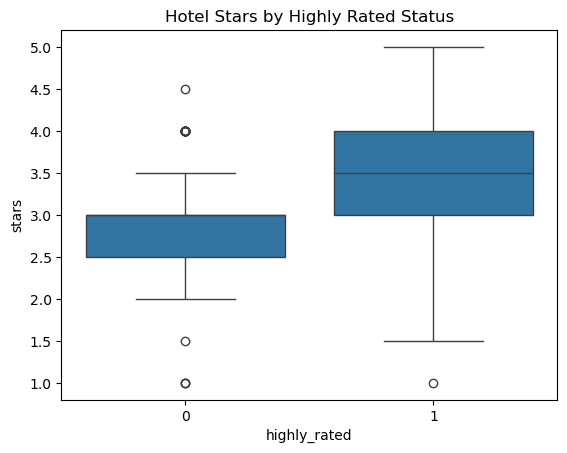

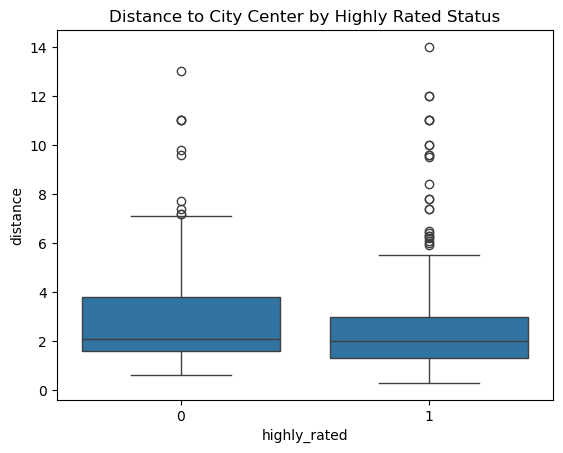

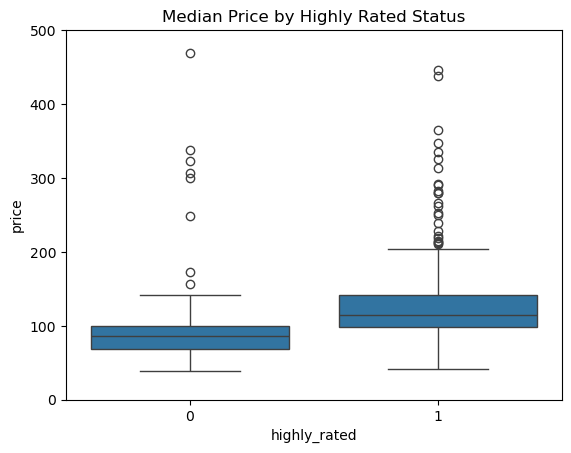

In [200]:
# -----------------------------------------
# 7. Examine Relationship between high rating with  the other hotel features
# -----------------------------------------

# Stars vs Highly Rated
sns.boxplot(x='highly_rated', y='stars', data=df_hotel)
plt.title('Hotel Stars by Highly Rated Status')
plt.show()

# Distance vs Highly Rated
sns.boxplot(x='highly_rated', y='distance', data=df_hotel)
plt.title('Distance to City Center by Highly Rated Status')
plt.show()

# Price vs Highly Rated
sns.boxplot(x='highly_rated', y='price', data=df_hotel)
plt.title('Median Price by Highly Rated Status')
plt.ylim(0,500) # limit outliers for visualization
plt.show()


#### Results Discussion:

- Hotels with higher star ratings appear more likely to be highly rated by users.  
- Distance to the city center shows a minor negative association with high ratings.  
- High-priced hotels are more likely to be highly rated.  

These exploratory plots justify further econometric modeling, e.g., LPM, Logit, or Probit, to quantify the effect of stars, distance, and other features on the probability of a hotel being highly rated.


In [201]:
# -----------------------------------------
# 8. Descriptive statistics
# -----------------------------------------
print("\nDescriptive statistics:")
print(df_hotel[["highly_rated", "rating", "distance", "stars", "price"]].describe().round(3))


Descriptive statistics:
       highly_rated   rating  distance    stars     price
count       559.000  559.000   559.000  559.000   559.000
mean          0.564    3.919     2.797    3.286   128.279
std           0.496    0.548     2.112    0.796   125.098
min           0.000    1.000     0.300    1.000    39.000
25%           0.000    3.700     1.500    3.000    82.750
50%           1.000    4.000     2.100    3.000   101.500
75%           1.000    4.400     3.450    4.000   126.000
max           1.000    5.000    14.000    5.000  1546.000


In [202]:
# -----------------------------------------
# 9. Linear Probability Model (LPM)
# -----------------------------------------
lpm = smf.ols(
    "highly_rated ~ distance + stars",
    data=df_hotel
).fit(cov_type="HC3")

print("\nLPM Results")
print(lpm.summary())


LPM Results
                            OLS Regression Results                            
Dep. Variable:           highly_rated   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     85.56
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           4.02e-33
Time:                        18:50:52   Log-Likelihood:                -343.01
No. Observations:                 559   AIC:                             692.0
Df Residuals:                     556   BIC:                             705.0
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2995      0.088     -3

In [203]:
# -----------------------------------------
# 10. Logit Model
# -----------------------------------------
logit = smf.logit(
    "highly_rated ~ distance + stars",
    data=df_hotel
).fit(disp=False)

print("\nLogit Results")
print(logit.summary())

print("\nLogit Marginal Effects")
print(logit.get_margeff(at="mean").summary())


Logit Results
                           Logit Regression Results                           
Dep. Variable:           highly_rated   No. Observations:                  559
Model:                          Logit   Df Residuals:                      556
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.1526
Time:                        18:50:52   Log-Likelihood:                -324.50
converged:                       True   LL-Null:                       -382.95
Covariance Type:            nonrobust   LLR p-value:                 4.152e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0257      0.501     -8.032      0.000      -5.008      -3.043
distance      -0.0361      0.044     -0.831      0.406      -0.121       0.049
stars          1.3557      0.147     

In [204]:
# -----------------------------------------
# 11. Probit Model
# -----------------------------------------
probit = smf.probit(
    "highly_rated ~ distance + stars",
    data=df_hotel
).fit(disp=False)

print("\nProbit Results")
print(probit.summary())

print("\nProbit Marginal Effects")
print(probit.get_margeff(at="mean").summary())


Probit Results
                          Probit Regression Results                           
Dep. Variable:           highly_rated   No. Observations:                  559
Model:                         Probit   Df Residuals:                      556
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.1532
Time:                        18:50:52   Log-Likelihood:                -324.30
converged:                       True   LL-Null:                       -382.95
Covariance Type:            nonrobust   LLR p-value:                 3.377e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3957      0.283     -8.479      0.000      -2.949      -1.842
distance      -0.0235      0.026     -0.910      0.363      -0.074       0.027
stars          0.8128      0.082    

In [205]:
# -----------------------------------------
# 12. Predicted probabilities
# -----------------------------------------
df_hotel["pred_lpm"] = lpm.predict(df_hotel)
df_hotel["pred_logit"] = logit.predict(df_hotel)
df_hotel["pred_probit"] = probit.predict(df_hotel)

print("\nMean predicted probabilities:")
print(df_hotel[["pred_lpm", "pred_logit", "pred_probit"]].mean())


Mean predicted probabilities:
pred_lpm       0.563506
pred_logit     0.563506
pred_probit    0.567838
dtype: float64


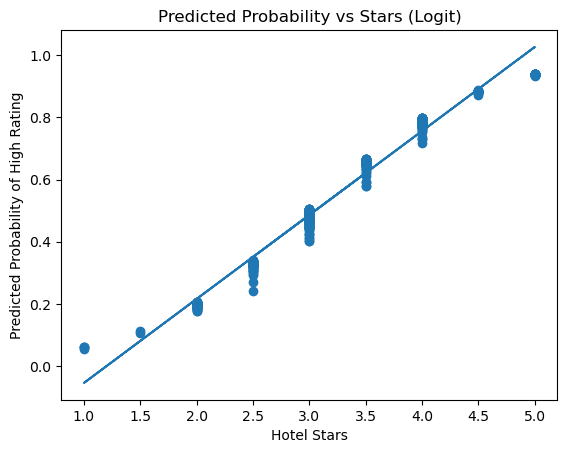

In [206]:
# =========================================
# 13. Scatter plot: Predicted Probability vs Stars (Logit)
# =========================================
plt.figure()
plt.scatter(df_hotel["stars"], df_hotel["pred_logit"])

# Trend line
z_stars = np.polyfit(df_hotel["stars"], df_hotel["pred_logit"], 1)
p_stars = np.poly1d(z_stars)
plt.plot(
    df_hotel["stars"],
    p_stars(df_hotel["stars"])
)

plt.xlabel("Hotel Stars")
plt.ylabel("Predicted Probability of High Rating")
plt.title("Predicted Probability vs Stars (Logit)")
plt.show()

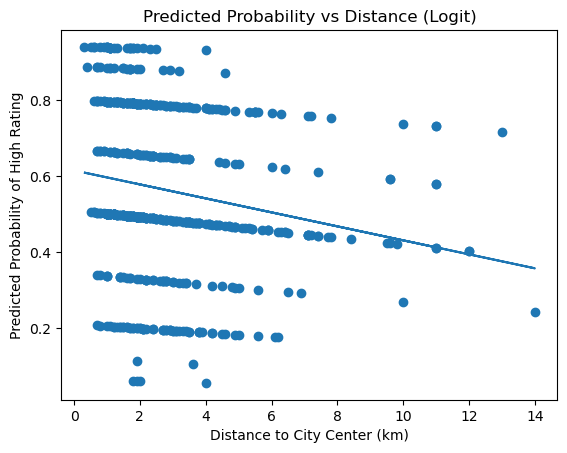

In [207]:
# =========================================
# 14. Scatter plot: Predicted Probability vs Distance (Logit)
# =========================================
plt.figure()
plt.scatter(df_hotel["distance"], df_hotel["pred_logit"])

# Trend line
z_dist = np.polyfit(df_hotel["distance"], df_hotel["pred_logit"], 1)
p_dist = np.poly1d(z_dist)
plt.plot(
    df_hotel["distance"],
    p_dist(df_hotel["distance"])
)

plt.xlabel("Distance to City Center (km)")
plt.ylabel("Predicted Probability of High Rating")
plt.title("Predicted Probability vs Distance (Logit)")
plt.show()
